In [1]:
#import modules
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw
from pkg_resources import non_empty_lines
import os
import glob
from matplotlib.lines import Line2D

/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_83743/1184203730.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import non_empty_lines


In [2]:
# stn = '037'
#
# # Paths
# data_path = f'/Users/iw2g24/PycharmProjects/COOKIES/Data/ctd_data/in2026_v01_{stn}/'
# data_file = f'in2026_v01_{stn}_data.cnv'     # your data file
# header_file = f'in2026_v01_{stn}_header.txt' # your header file
#
# # --- Step 1: Extract column names from header ---
# column_names = []
# header_path = data_path + header_file
#
# with open(header_path, 'r') as f:
#     for line in f:
#         if line.startswith('# name'):
#             # Grab text after '=' and before ':' (short name)
#             name_part = line.split('=')[1].strip()
#             short_name = name_part.split(':')[0].strip()
#             column_names.append(short_name)
#         if line.startswith('*END*'):
#             break
#
# print("Extracted column names:")
# print(column_names)
#
# # --- Step 2: Find where the data starts in the .cnv file ---
# data_path_full = data_path + data_file
# data_start = 0
# with open(data_path_full, 'r') as f:
#     for i, line in enumerate(f):
#         if line.startswith('*END*'):
#             data_start = i + 1  # data starts on next line
#             break
#
# # --- Step 3: Read the data using pandas ---
# data = pd.read_csv(
#     data_path_full,
#     sep=r'\s+',             # future-proof way to handle whitespace
#     names=column_names,
#     skiprows=data_start,
#     comment='#',             # ignore any leftover comment lines
#     engine='python'          # recommended when using regex separators
# )
#
#
# # --- Step 4: Inspect the data ---
# # print(data.head())
# print(data.info())
#
# # Replace '/' with 'per' and spaces with '_'
# # sanitized_columns = [col.replace('/', 'per').replace(' ', '_') for col in data.columns]
# sanitized_columns = [
#     col.replace('/', 'per')
#        .replace(' ', '_')
#        .replace('-', '_')
#     for col in data.columns
# ]
#
#
# # Apply the sanitized names to the DataFrame
# data.columns = sanitized_columns
#
# print("Sanitized column names:")
# print(data.columns)
#
# # Define units for each variable (from header info)
# units_dict = {
#     't090C': 'degC',
#     'c0S_per_m': 'S/m',
#     'prDM': 'db',
#     't190C': 'degC',
#     'c1S_per_m': 'S/m',
#     'sbeox0Mm_per_L': 'umol/L',
#     'sbeox1Mm_per_L': 'umol/L',
#     'par': 'umol/m2/s',       # typical PAR units
#     'altM': 'm',
#     'wetCDOM': 'mg/m3',
#     'CStarTr0': '%',
#     'flECO_AFL': 'mg/m3',
#     'turbWETbb0': 'm^-1/sr',
#     'ptempC': 'degC',
#     'pumps': 'status',         # could be integer flags
#     'bpos': 'index',           # integer
#     'nbf': 'count',            # integer
#     'sal00': 'PSU',
#     'sal11': 'PSU',
#     'longitude': 'degrees_east',
#     'latitude': 'degrees_north',
#     'scan': 'count',
#     'timeS': 'seconds',
#     'flag': 'unitless'
# }
#
# # --- Step 2: Convert DataFrame to xarray Dataset ---
# ds = xr.Dataset.from_dataframe(data)
#
# # --- Step 3: Add variable attributes (units) ---
# for var in ds.data_vars:
#     if var in units_dict:
#         ds[var].attrs['units'] = units_dict[var]
#
#
# # --- Step 4: (Optional) Add global metadata ---
# ds.attrs['title'] = f'CTD Cast IN2026_V01_{stn}'
# ds.attrs['instrument'] = 'SBE 9 / SBE 43 / ECO sensors'
# ds.attrs['location'] = 'Cook Strait / Investigator'
# ds.attrs['source'] = 'Raw CTD .cnv converted to NetCDF'
#
#
# # --- Select variables ---
# SP = ds['sal00'].values        # Practical Salinity (PSU)
# t = ds['t090C'].values         # In-situ temperature (°C)
# p = ds['prDM'].values          # Pressure (dbar)
#
# lon = ds['longitude'].values
# lat = ds['latitude'].values
#
# # --- Convert to Absolute Salinity ---
# SA = gsw.SA_from_SP(SP, p, lon, lat)  # g/kg
#
# # --- Convert to Conservative Temperature ---
# CT = gsw.CT_from_t(SA, t, p)           # degC
#
# # --- Compute in-situ density ---
# rho = gsw.rho(SA, CT, p)               # kg/m^3
#
# # --- Compute potential density anomalies ---
# sigma0 = gsw.sigma0(SA, CT)   # reference 0 dbar
# sigma1 = gsw.sigma1(SA, CT)   # reference 1000 dbar
# sigma2 = gsw.sigma2(SA, CT)   # reference 2000 dbar
# sigma3 = gsw.sigma3(SA, CT)   # reference 3000 dbar
#
# # --- Add sigma variables to Dataset ---
# ds['sigma0'] = (ds['sal00'].dims, sigma0)
# ds['sigma1'] = (ds['sal00'].dims, sigma1)
# ds['sigma2'] = (ds['sal00'].dims, sigma2)
# ds['sigma3'] = (ds['sal00'].dims, sigma3)
#
# # --- Add attributes ---
# ds['sigma0'].attrs.update({
#     'long_name': 'Potential density anomaly referenced to 0 dbar',
#     'units': 'kg m-3',
#     'standard_name': 'sea_water_sigma_theta',
#     'comment': 'Computed using TEOS-10 (GSW)'
# })
#
# ds['sigma1'].attrs.update({
#     'long_name': 'Potential density anomaly referenced to 1000 dbar',
#     'units': 'kg m-3',
#     'comment': 'Computed using TEOS-10 (GSW)'
# })
#
# ds['sigma2'].attrs.update({
#     'long_name': 'Potential density anomaly referenced to 2000 dbar',
#     'units': 'kg m-3',
#     'comment': 'Computed using TEOS-10 (GSW)'
# })
#
# ds['sigma3'].attrs.update({
#     'long_name': 'Potential density anomaly referenced to 3000 dbar',
#     'units': 'kg m-3',
#     'comment': 'Computed using TEOS-10 (GSW)'
# })
#
# ds['SA'] = (ds['sal00'].dims, SA)
# ds['SA'].attrs['long_name'] = 'Absolute Salinity'
# ds['SA'].attrs['units'] = 'g kg-1'
#
# ds['CT'] = (ds['sal00'].dims, CT)
# ds['CT'].attrs['long_name'] = 'Conservative Temperature'
# ds['CT'].attrs['units'] = 'degC'
#
# ds['density'] = (ds['sal00'].dims, rho)
# ds['density'].attrs['long_name'] = 'In-situ density'
# ds['density'].attrs['units'] = 'kg m-3'
#
#
# ds['SA'].attrs.update({
#     'long_name': 'Absolute Salinity',
#     'units': 'g kg-1',
#     'standard_name': 'sea_water_absolute_salinity'
# })
#
# ds['CT'].attrs.update({
#     'long_name': 'Conservative Temperature',
#     'units': 'degC',
#     'standard_name': 'sea_water_conservative_temperature'
# })
#
# ds['prDM'].attrs.update({
#     'standard_name': 'sea_water_pressure',
#     'positive': 'down'
# })
#
#
# # --- Step 5: Save to NetCDF ---
# # save_path = os.path.join(data_path, 'new')
# save_path = os.path.join(data_path)
# os.makedirs(save_path, exist_ok=True)
#
# nc_file = os.path.join(save_path, f'in2026_v01_{stn}.nc')
# ds.to_netcdf(nc_file)
#
# print(f"Saved NetCDF file: {nc_file}")


In [3]:
data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/ctd_data/'

# Find all NetCDF files
files = glob.glob(os.path.join(data_dir, 'in2026_v01_*', 'in2026_v01_*.nc'))

# Sort numerically by station number
files = sorted(files, key=lambda f: int(os.path.basename(f).split('_')[-1].split('.')[0]))

datasets = {}
stations_all = []

for file_name in files:
    stn = os.path.basename(file_name).split('_')[-1].split('.')[0]
    stations_all.append(stn)
    datasets[stn] = xr.open_dataset(file_name, decode_timedelta=False)
    print(f"Opened dataset for station {stn}")




Opened dataset for station 001
Opened dataset for station 002
Opened dataset for station 003
Opened dataset for station 004
Opened dataset for station 005
Opened dataset for station 006
Opened dataset for station 007
Opened dataset for station 008
Opened dataset for station 009
Opened dataset for station 010
Opened dataset for station 011
Opened dataset for station 012
Opened dataset for station 013
Opened dataset for station 014
Opened dataset for station 015
Opened dataset for station 016
Opened dataset for station 017
Opened dataset for station 018
Opened dataset for station 019
Opened dataset for station 020
Opened dataset for station 021
Opened dataset for station 022
Opened dataset for station 023
Opened dataset for station 024
Opened dataset for station 025
Opened dataset for station 026
Opened dataset for station 027
Opened dataset for station 028
Opened dataset for station 029
Opened dataset for station 030
Opened dataset for station 031
Opened dataset for station 032
Opened d

In [4]:
"""
save variable gradients for Laura

"""
# # Save some variables to a csv file for Laura de Santis (plot against internal waves)
# out_dir = os.path.join(data_dir, 'csv_for_Laura')
# os.makedirs(out_dir, exist_ok=True)
#
# for stn, ds in datasets.items():
#
#     # --- Extract data - numpy array
#     pressure = ds.prDM.values
#     ab_sal = ds.SA.values
#     conservative_T = ds.CT.values
#     sigma0 = ds.sigma0.values
#     longitude = ds.longitude.values
#     latitude = ds.latitude.values
#
#     # calculate gradient for each variable
#     p_grad = np.gradient(pressure)
#     ab_sal_grad = np.gradient(ab_sal)
#     conservative_T_grad = np.gradient(conservative_T)
#     sigma0_grad = np.gradient(sigma0)
#
#     # --- Build DataFrame
#     df = pd.DataFrame({
#         'pressure': pressure,
#         'pressure_grad': p_grad,
#         'absolute_sal': ab_sal,
#         'absolute_sal_grad': ab_sal_grad,
#         'conservative_T': conservative_T,
#         'conservative_T_grad': conservative_T_grad,
#         'potential_density_0': sigma0,
#         'potential_density_grad': sigma0_grad,
#         'longitude': longitude,
#         'latitude': latitude
#     })
#
#     # --- Write CSV
#     out_file = os.path.join(out_dir, f'in2026_v01_{stn}.csv')
#     df.to_csv(out_file, sep='\t', index=False)
#
#     print(f"Wrote CSV for station {stn}")
#
#     # --- Close dataset to free memory
#     ds.close()


'\nsave variable gradients for Laura\n\n'

In [5]:
# stations_waves = ['018', '020', '021', '022', '023'] #sediment waves  # ← edit as needed
#
# grad_vars = [
#     ('absolute_sal_grad', 'dSA'),
#     ('conservative_T_grad', 'dCT'),
#     ('potential_density_grad', 'dSigma0'),
#     ('pressure_grad', 'dP')
# ]
#
#
# y_min = 0
# y_max = 600
#
# start = None
# end = None
# sl = slice(start, end)
#
# for stn in stations_waves:
#
#     file = os.path.join(
#         data_dir,
#         'csv_for_Laura',
#         f'in2026_v01_{stn}.csv'
#     )
#
#     df = pd.read_csv(file, sep='\t')
#
#     pressure = df['pressure'].values
#
#     fig, axs = plt.subplots(1, len(grad_vars), figsize=(18, 7))
#     fig.suptitle(f'Station {stn} – Vertical Gradients', fontsize=14)
#
#     for ax, (var, label) in zip(axs, grad_vars):
#
#         mask = pressure > 8.5
#         ax.plot(df[var].values[mask], pressure[mask])
#         ax.set_title(label)
#         ax.set_ylim(y_min, y_max)
#         ax.invert_yaxis()
#         ax.tick_params(axis='x', labelrotation=45)
#
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()
#
#


In [6]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import os
#
# y_min = 0
# y_max = 600
#
# start = None
# end = None
# sl = slice(start, end)
#
# for var, label in grad_vars:
#
#     fig, ax = plt.subplots(figsize=(4, 5))
#     ax.set_title(label)
#
#     for stn in stations_waves:
#
#         file = os.path.join(
#             data_dir,
#             'csv_for_Laura',
#             f'in2026_v01_{stn}.csv'
#         )
#
#         df = pd.read_csv(file, sep='\t')
#
#         pressure = df['pressure'].values
#         grad = df[var].values
#
#         mask = pressure > 8.5
#         ax.plot(grad[mask], pressure[mask], label=f'St {stn}')
#
#
#     ax.set_ylim(y_min, y_max)
#     ax.invert_yaxis()
#     ax.tick_params(axis='x', labelrotation=45)
#     ax.set_ylabel('Pressure')
#     ax.legend()
#
#     plt.tight_layout()
#     plt.show()


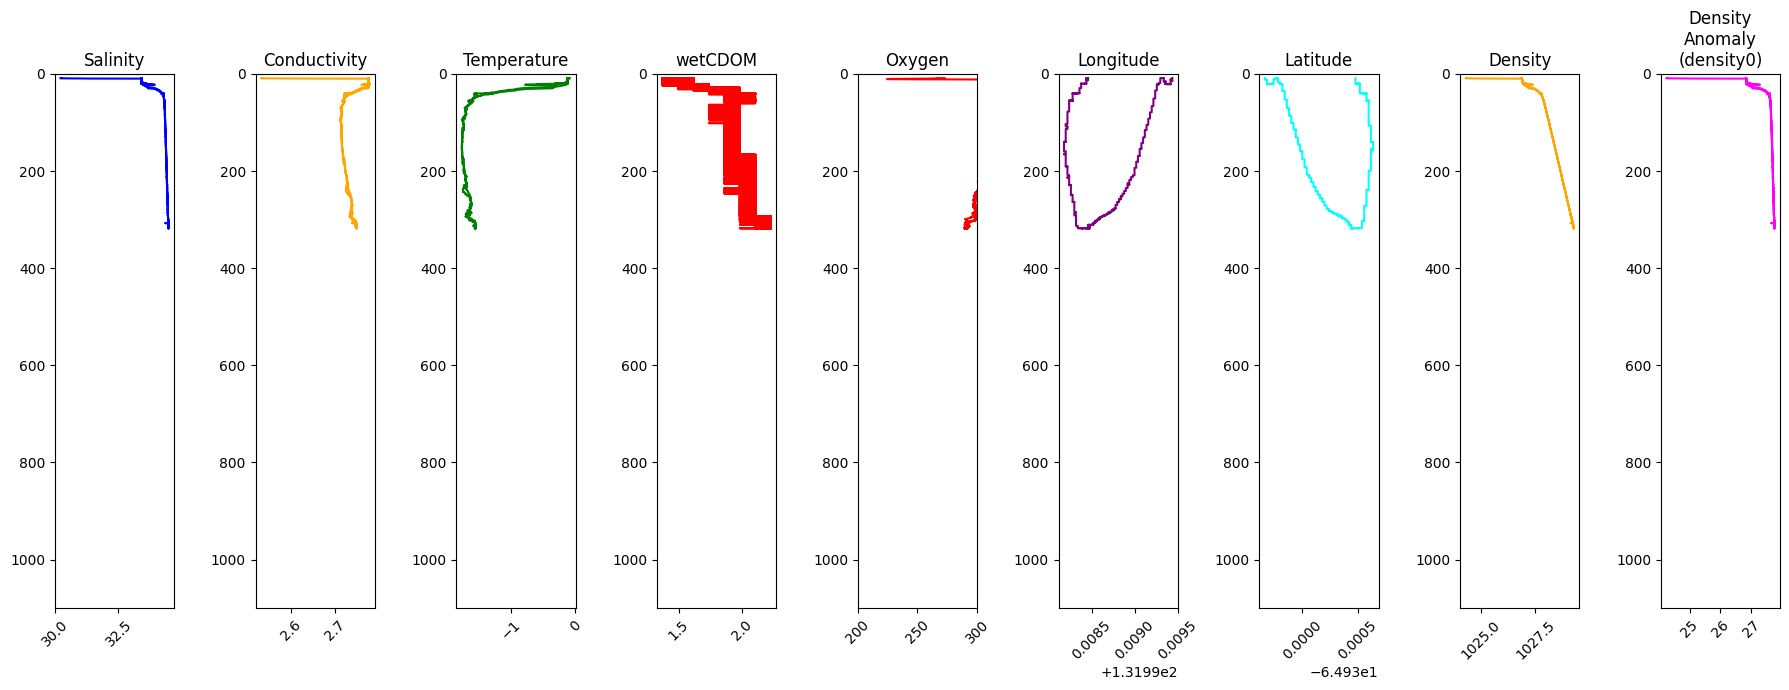

In [8]:
stn = '029'
ds_name = str(f'ds_{stn}')
data = datasets[f'{stn}']

pressure =data.prDM.values
temp1 = data.t090C.values
conductivity = data.c0Sperm.values
salinity =data.sal00.values
fluro = data.flECO_AFL.values
fluro_2 = data.wetCDOM.values
time = data.timeS.values
longitude = data.longitude.values
latitude = data.latitude.values
density = data.density.values
sigma0 = data.sigma0.values
oxygen = data.sbeox0MmperL.values
temp2 = data.t190C.values
conductivity2 = data.c1Sperm.values

mask = pressure > 8.5

pressure = pressure[mask]
salinity= salinity[mask]
conductivity = conductivity[mask]
temp1 = temp1[mask]
fluro = fluro[mask]
longitude = longitude[mask]
latitude = latitude[mask]
density = density[mask]
sigma0= sigma0[mask]
oxygen = oxygen[mask]
wetCDOM = data.wetCDOM[mask]



# Create a figure and a set of 1 row, 9 columns of subplots
y_min = 0
y_max = 1100

# start = 13000
# end = -13000

start = None
end = None



fig, axs = plt.subplots(1, 9, figsize=(18, 7))

# Helper slice
sl = slice(start, end)

# Salinity
axs[0].plot(salinity[sl], pressure[sl], color='blue')
axs[0].set_title('Salinity')
axs[0].set_ylim(y_min, y_max)
axs[0].invert_yaxis()
axs[0].tick_params(axis='x', labelrotation=45)

# Conductivity
axs[1].plot(conductivity[sl], pressure[sl], color='orange')
axs[1].set_title('Conductivity')
axs[1].set_ylim(y_min, y_max)
axs[1].invert_yaxis()
axs[1].tick_params(axis='x', labelrotation=45)

# Temperature
axs[2].plot(temp1[sl], pressure[sl], color='green')
axs[2].set_title('Temperature')
axs[2].set_ylim(y_min, y_max)
axs[2].invert_yaxis()
axs[2].tick_params(axis='x', labelrotation=45)

# Fluorescence
axs[3].plot(wetCDOM[sl], pressure[sl], color='red')
axs[3].set_title('wetCDOM')
axs[3].set_ylim(y_min, y_max)
axs[3].invert_yaxis()
axs[3].tick_params(axis='x', labelrotation=45)

# oxygen
axs[4].plot(oxygen[sl], pressure[sl], color='red')
axs[4].set_title('Oxygen')
axs[4].set_ylim(y_min, y_max)
axs[4].invert_yaxis()
axs[4].set_xlim(200, 300)
axs[4].tick_params(axis='x', labelrotation=45)

# Longitude
axs[5].plot(longitude[sl], pressure[sl], color='purple')
axs[5].set_title('Longitude')
axs[5].set_ylim(y_min, y_max)
axs[5].invert_yaxis()
axs[5].tick_params(axis='x', labelrotation=45)

# Latitude
axs[6].plot(latitude[sl], pressure[sl], color='cyan')
axs[6].set_title('Latitude')
axs[6].set_ylim(y_min, y_max)
axs[6].invert_yaxis()
axs[6].tick_params(axis='x', labelrotation=45)

# Density
axs[7].plot(density[sl], pressure[sl], color='orange')
axs[7].set_title('Density')
axs[7].set_ylim(y_min, y_max)
axs[7].invert_yaxis()
axs[7].tick_params(axis='x', labelrotation=45)

# Density anomaly
axs[8].plot(sigma0[sl], pressure[sl], color='magenta')
axs[8].set_title('Density\nAnomaly\n(density0)')
axs[8].set_ylim(y_min, y_max)
axs[8].invert_yaxis()
axs[8].tick_params(axis='x', labelrotation=45)


plt.tight_layout()
plt.show()


In [9]:
mean_lon = []
mean_lat = []

for stn in stations_all:
    ds = datasets[stn]

    lon = ds.longitude.values
    lat = ds.latitude.values
    pressure = ds.prDM.values

    mask = pressure > 8.5
    longitude = lon[mask]
    latitude = lat[mask]

    lon_mean = np.mean(longitude)
    lat_mean = np.mean(latitude)

    mean_lon.append(lon_mean)
    mean_lat.append(lat_mean)

    print(f"Mean lon/lat at {stn}: {lon_mean:.4f} / {lat_mean:.4f}")

Mean lon/lat at 001: 147.7191 / -48.0690
Mean lon/lat at 002: 149.2789 / -57.7022
Mean lon/lat at 003: 150.0142 / -62.4966
Mean lon/lat at 004: 150.0012 / -63.5015
Mean lon/lat at 005: 150.0224 / -63.8765
Mean lon/lat at 006: 151.6070 / -63.4685
Mean lon/lat at 007: 146.6632 / -64.5711
Mean lon/lat at 008: 150.0001 / -65.0003
Mean lon/lat at 009: 150.0002 / -64.5998
Mean lon/lat at 010: 148.0286 / -65.1674
Mean lon/lat at 011: 147.3295 / -65.1580
Mean lon/lat at 012: 147.0278 / -65.1986
Mean lon/lat at 013: 147.5504 / -65.4451
Mean lon/lat at 014: 147.4840 / -65.4496
Mean lon/lat at 015: 147.8506 / -65.4258
Mean lon/lat at 016: 147.7556 / -65.1655
Mean lon/lat at 017: 146.9691 / -65.4558
Mean lon/lat at 018: 151.6603 / -64.8703
Mean lon/lat at 019: 151.6588 / -64.8585
Mean lon/lat at 020: 151.6600 / -64.8705
Mean lon/lat at 021: 151.6602 / -64.8705
Mean lon/lat at 022: 151.6605 / -64.8701
Mean lon/lat at 023: 151.6608 / -64.8703
Mean lon/lat at 024: 151.6150 / -64.7769
Mean lon/lat at 

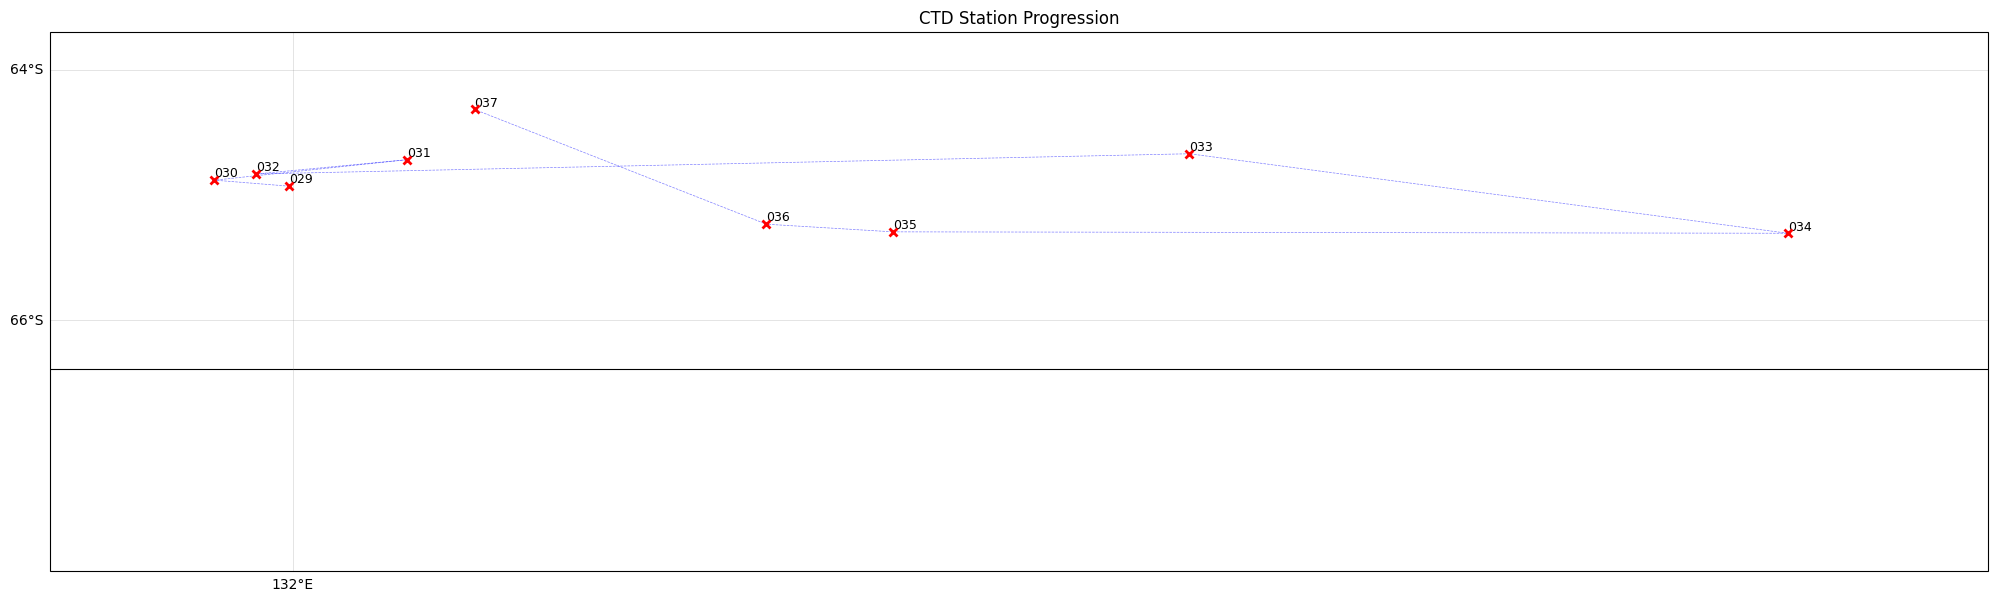

In [10]:
proj = ccrs.PlateCarree()

lon_min, lon_max = 131.9, 132.7
lat_min, lat_max = -63.7, -68

fig = plt.figure(figsize=(25, 7))
ax = plt.axes(projection=proj)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs = proj)
ax.set_aspect('auto')
# Coastlines
ax.coastlines(resolution='110m', linewidth=0.8)

mean_lon = np.array(mean_lon)
mean_lat = np.array(mean_lat)
stations_all = np.array(stations_all)

mask = (
    (mean_lat <= lat_min) & (mean_lat >= lat_max) &
    (mean_lon >= lon_min) & (mean_lon <= lon_max)
)

mean_lon_plot = mean_lon[mask]
mean_lat_plot = mean_lat[mask]
stations_plot = stations_all[mask]


# Line (transparent)
ax.plot(
    mean_lon_plot,
    mean_lat_plot,
    linestyle='--',
    color='blue',
    linewidth=0.5,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
    zorder=4
)

# Markers (fully opaque)
ax.plot(
    mean_lon_plot,
    mean_lat_plot,
    linestyle='None',
    marker='x',
    color='red',
    markersize=6,
    markeredgewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# stations = ['001', '002', '003', '004', '005', '006', '007', '008', '009','010', '011', '012', '013']

# Label stations
for stn, lon, lat in zip(stations_plot, mean_lon_plot, mean_lat_plot):
    ax.text(
        lon, lat, stn,
        transform=ccrs.PlateCarree(),
        fontsize=9,
        ha='left',
        va='bottom'
    )

# -------------------------
# Gridlines + lon/lat ticks
# -------------------------
lon_ticks = np.arange(-180, 181, 2)   # adjust spacing as needed
lat_ticks = np.arange(-90, 91, 2)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.3,
    linestyle='-',
    xlocs=lon_ticks,
    ylocs=lat_ticks
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_ylim(lat_max, lat_min)

ax.set_title("CTD Station Progression")

plt.show()


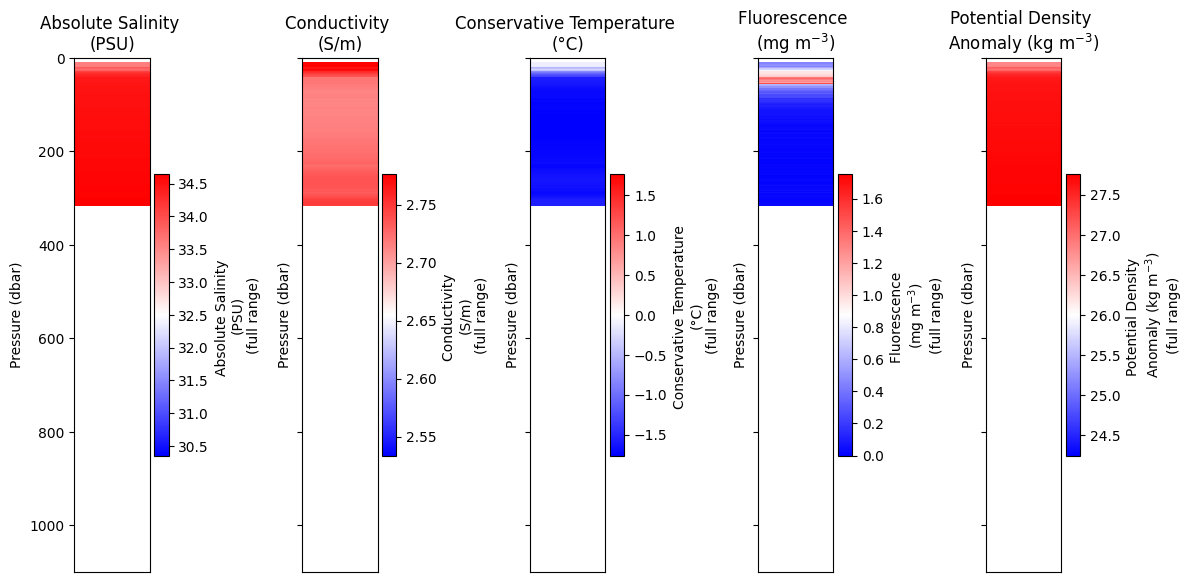

In [11]:
pressure =data.prDM.values
# temp1 = data.t090C.values
temp1 = data.CT.values
conductivity = data.c0Sperm.values
salinity =data.SA.values
fluro = data.flECO_AFL.values
time = data.timeS.values
longitude = data.longitude.values
latitude = data.latitude.values
density = data.density.values
sigma0 = data.sigma0.values

# --- Pressure mask (CTD in water) ---
mask = pressure > 8.5

# Apply mask
pressure_m = pressure[mask]
salinity_m = salinity[mask]
conductivity_m = conductivity[mask]
temp1_m = temp1[mask]
fluro_m = fluro[mask]
sigma0_m = sigma0[mask]
density_m = density[mask]

# --- Compute pressure edges (masked) ---
pressure_edges = np.zeros(len(pressure_m) + 1)
pressure_edges[1:-1] = (pressure_m[:-1] + pressure_m[1:]) / 2
pressure_edges[0] = pressure_m[0] - (pressure_m[1] - pressure_m[0]) / 2
pressure_edges[-1] = pressure_m[-1] + (pressure_m[-1] - pressure_m[-2]) / 2

# # --- Variables (no clipping) ---
# variables = [
#     (salinity_m, "Salinity \n(PSU)", "bwr"),
#     (conductivity_m, "Conductivity \n(S/m)", "bwr"),
#     (temp1_m, "Temperature \n(°C)", "bwr"),
#     (fluro_m, "Fluorescence \n(mg m$^{-3}$)", "bwr"),
#     (density0_m, "Potential Density \nAnomaly (kg m$^{-3}$)", "bwr"),
#     # (density_m, " Density \n(kg m$^{-3}$)", "bwr"),
# ]

variables = [
    (salinity_m, "Absolute Salinity \n(PSU)", "bwr", None),
    (conductivity_m, "Conductivity \n(S/m)", "bwr", None),
    (temp1_m, "Conservative Temperature \n(°C)", "bwr", "symmetric"),
    (fluro_m, "Fluorescence \n(mg m$^{-3}$)", "bwr", None),
    (sigma0_m, "Potential Density \nAnomaly (kg m$^{-3}$)", "bwr", None),
]


# --- Create subplots ---
fig, axs = plt.subplots(1, 5, figsize=(12, 6), sharey=True)

for ax, (var, title, cmap, scale) in zip(axs, variables):

    if scale == "symmetric":
        vmax = np.nanmax(np.abs(var))
        vmin = -vmax
    else:
        vmin = np.nanmin(var)
        vmax = np.nanmax(var)

    pcm = ax.pcolormesh(
        [0, 1],
        pressure_edges,
        var[:, None],
        shading="auto",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_xticks([])
    ax.set_title(title)
    ax.set_ylabel("Pressure (dbar)")
    ax.set_ylim(0, 1100)

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(f"{title}\n(full range)")


axs[0].invert_yaxis()
plt.tight_layout()
plt.show()


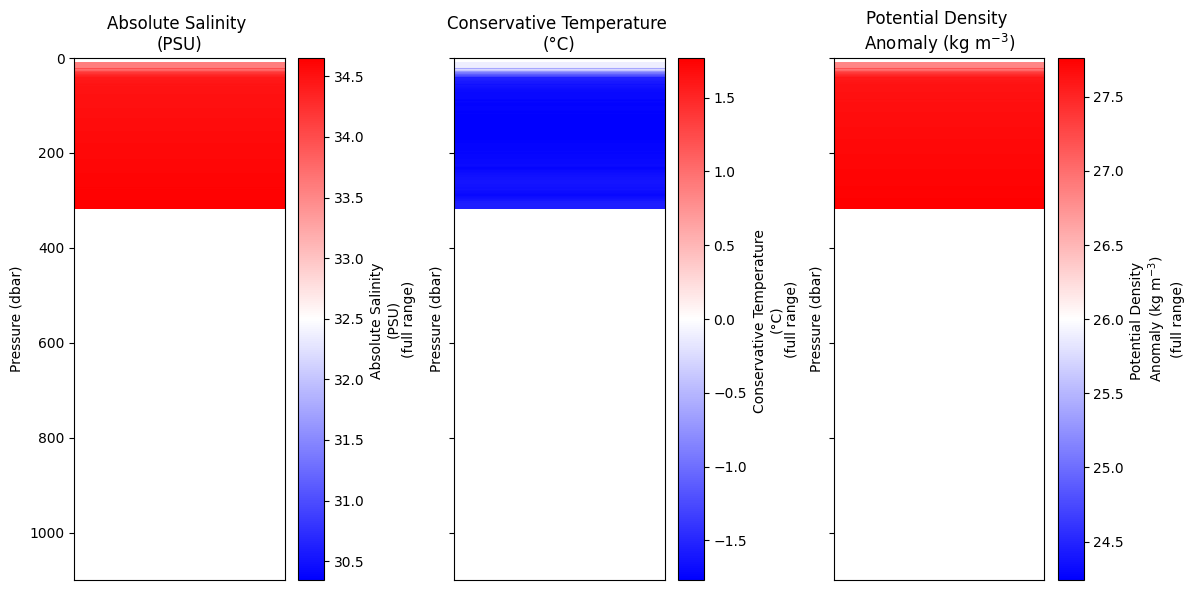

In [12]:
pressure =data.prDM.values
# temp1 = data.t090C.values
temp1 = data.CT.values
conductivity = data.c0Sperm.values
salinity =data.SA.values
fluro = data.flECO_AFL.values
time = data.timeS.values
longitude = data.longitude.values
latitude = data.latitude.values
density = data.density.values
sigma0 = data.sigma0.values

# --- Pressure mask (CTD in water) ---
mask = pressure > 8.5

# Apply mask
pressure_m = pressure[mask]
salinity_m = salinity[mask]
conductivity_m = conductivity[mask]
temp1_m = temp1[mask]
fluro_m = fluro[mask]
sigmay0_m = sigma0[mask]
density_m = density[mask]

# --- Compute pressure edges (masked) ---
pressure_edges = np.zeros(len(pressure_m) + 1)
pressure_edges[1:-1] = (pressure_m[:-1] + pressure_m[1:]) / 2
pressure_edges[0] = pressure_m[0] - (pressure_m[1] - pressure_m[0]) / 2
pressure_edges[-1] = pressure_m[-1] + (pressure_m[-1] - pressure_m[-2]) / 2

# # --- Variables (no clipping) ---
# variables = [
#     (salinity_m, "Salinity \n(PSU)", "bwr"),
#     (conductivity_m, "Conductivity \n(S/m)", "bwr"),
#     (temp1_m, "Temperature \n(°C)", "bwr"),
#     (fluro_m, "Fluorescence \n(mg m$^{-3}$)", "bwr"),
#     (density0_m, "Potential Density \nAnomaly (kg m$^{-3}$)", "bwr"),
#     # (density_m, " Density \n(kg m$^{-3}$)", "bwr"),
# ]

variables = [
    (salinity_m, "Absolute Salinity \n(PSU)", "bwr", None),
    (temp1_m, "Conservative Temperature \n(°C)", "bwr", "symmetric"),
    (sigma0_m, "Potential Density \nAnomaly (kg m$^{-3}$)", "bwr", None),
]


# --- Create subplots ---
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

for ax, (var, title, cmap, scale) in zip(axs, variables):

    if scale == "symmetric":
        vmax = np.nanmax(np.abs(var))
        vmin = -vmax
    else:
        vmin = np.nanmin(var)
        vmax = np.nanmax(var)

    pcm = ax.pcolormesh(
        [0, 1],
        pressure_edges,
        var[:, None],
        shading="auto",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_xticks([])
    ax.set_title(title)
    ax.set_ylabel("Pressure (dbar)")
    ax.set_ylim(0, 1100)

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(f"{title}\n(full range)")


axs[0].invert_yaxis()
plt.tight_layout()
plt.show()


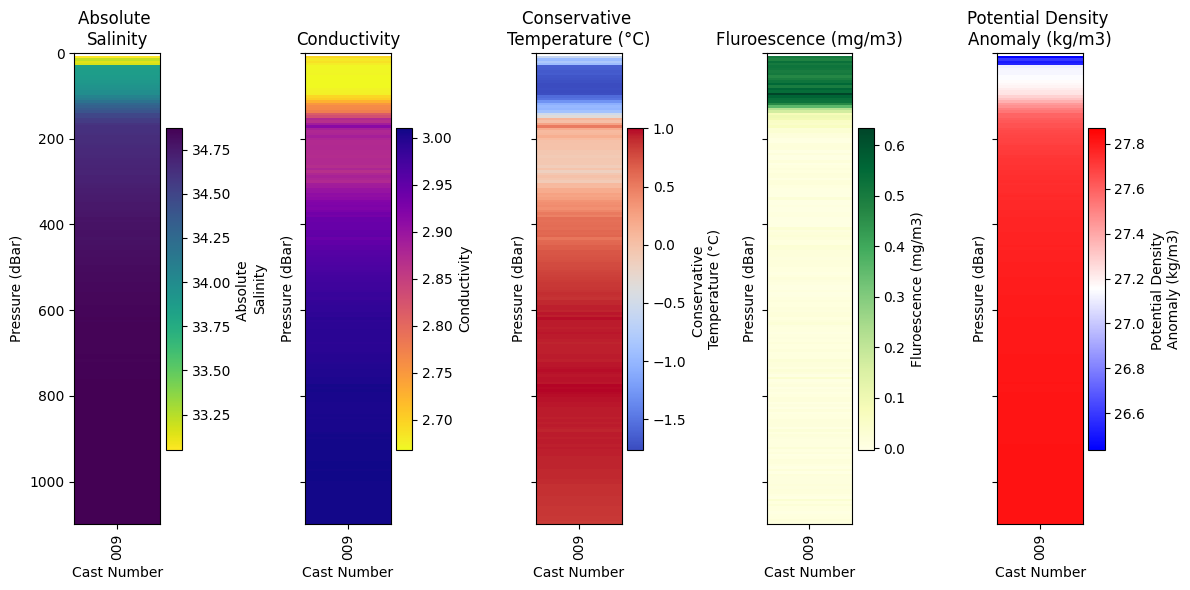

In [13]:
pressures = []
temps = []
sals = []
conds = []
fluro = []
rho0 = []

stations = ['009']

y_min = 0
y_max = 1100

for stn in stations:
    ds = datasets[stn]

    # --- Extract variables ---
    p = ds.prDM.values
    # t = ds.t090C.values
    # s = ds.sal00.values
    t = ds.CT.values
    s = ds.SA.values
    c = ds.c0Sperm.values
    f = ds.flECO_AFL.values
    rho_anom = ds.sigma0.values

    # --- Mask to in-water (pressure > 8.5 dbar) ---
    mask = p > 8.5
    p = p[mask]
    t = t[mask]
    s = s[mask]
    c = c[mask]
    f = f[mask]
    rho_anom = rho_anom[mask]

    # --- Sort by pressure (increasing) ---
    order = np.argsort(p)
    p = p[order]
    t = t[order]
    s = s[order]
    c = c[order]
    f = f[order]
    rho_anom = rho_anom[order]

    # --- Append to lists ---
    pressures.append(p)
    temps.append(t)
    sals.append(s)
    conds.append(c)
    fluro.append(f)
    rho0.append(rho_anom)

p_min = min(p[0] for p in pressures)
p_max = max(p[-1] for p in pressures)
p_grid = np.linspace(p_min, p_max, 600)

temp_grid = np.vstack([
    np.interp(p_grid, pressures[i], temps[i])
    for i in range(len(stations))
])

sal_grid = np.vstack([
    np.interp(p_grid, pressures[i], sals[i])
    for i in range(len(stations))
])

cond_grid = np.vstack([
    np.interp(p_grid, pressures[i], conds[i])
    for i in range(len(stations))
])

fluro_grid = np.vstack([
    np.interp(p_grid, pressures[i], fluro[i])
    for i in range(len(stations))
])

rho0_grid = np.vstack([
    np.interp(p_grid, pressures[i], rho0[i])
    for i in range(len(stations))
])

# # x: station index
x = np.arange(len(stations))
x_edges = np.arange(len(stations) + 1)

# y: pressure edges
p_edges = np.zeros(len(p_grid) + 1)
p_edges[1:-1] = (p_grid[:-1] + p_grid[1:]) / 2
p_edges[0] = p_grid[0] - (p_grid[1] - p_grid[0]) / 2
p_edges[-1] = p_grid[-1] + (p_grid[-1] - p_grid[-2]) / 2

fig, axs = plt.subplots(1, 5, figsize=(12, 6), sharey=True)

variables = [
    (sal_grid,  "Absolute \nSalinity",        "viridis_r", np.min(sal_grid), np.max(sal_grid)),

    (cond_grid, "Conductivity",    "plasma_r", np.min(cond_grid), np.max(cond_grid)),

    (temp_grid, "Conservative \nTemperature (°C)", "coolwarm", np.min(temp_grid), np.max(temp_grid)),

    (fluro_grid, "Fluroescence (mg/m3)", "YlGn", np.min(fluro_grid), np.max(fluro_grid)),

    (rho0_grid, 'Potential Density \nAnomaly (kg/m3)', 'bwr', np.min(rho0_grid), np.max(rho0_grid)),
]


for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x_edges,
        p_edges,
        var2d.T,        # shape must be (pressure, station)
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    # Set station numbers as x-ticks
    ax.set_xticks(x+0.5)
    ax.set_xticklabels(stations)
    ax.tick_params(axis='x', labelrotation=90)

    # ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Cast Number")
    ax.set_ylabel("Pressure (dBar)")


    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)


axs[0].set_ylim(y_min, y_max)
axs[0].invert_yaxis()
plt.tight_layout()
plt.show()


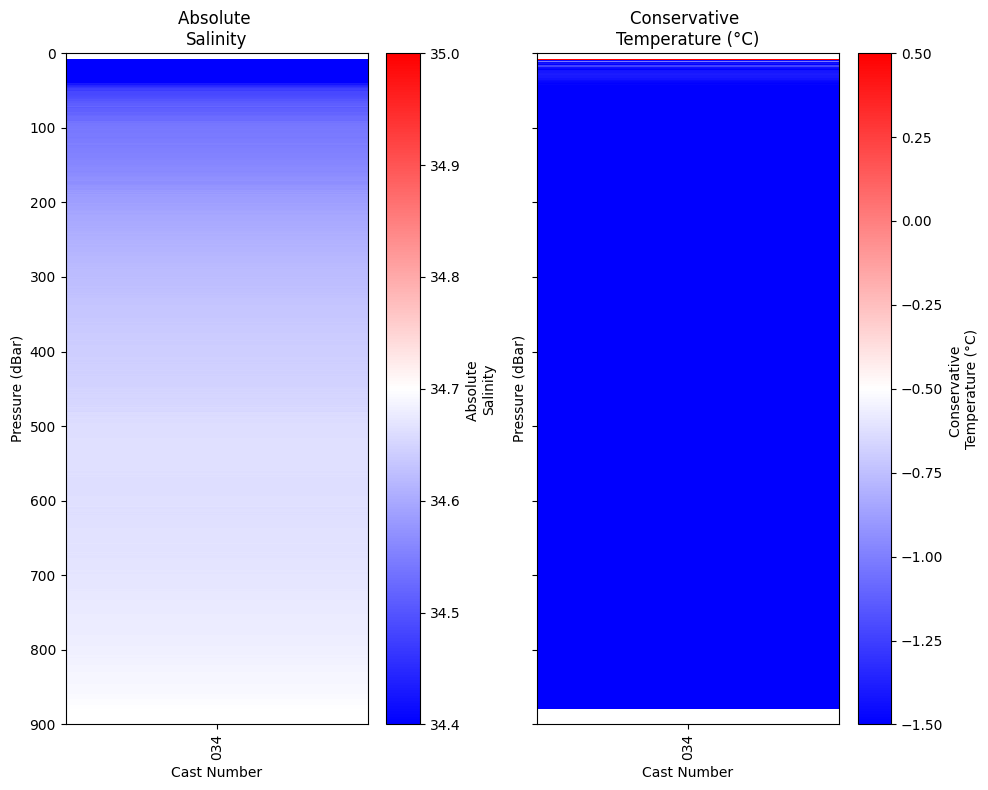

In [14]:
pressures = []
temps = []
sals = []
conds = []
fluro = []
rho0 = []

# stations = ['002', '003', '004', '005', '006', '007', '008', '009']
# stations = ['010', '016', '011', '012'] #northern transect
# stations = ['015', '014', '013', '017'] #southern transect
# stations = ['018', '020', '021', '022', '023'] #sediment waves

# stations = ['028', '029', '030', '031', '032', '033', '034'] #dibble
stations = ['034']

y_min = 0
y_max = 900

for stn in stations:
    ds = datasets[stn]

    # --- Extract variables ---
    p = ds.prDM.values
    # t = ds.t090C.values
    # s = ds.sal00.values
    t = ds.CT.values
    s = ds.SA.values
    c = ds.c0Sperm.values
    f = ds.flECO_AFL.values
    rho_anom = ds.sigma0.values

    # --- Mask to in-water (pressure > 8.5 dbar) ---
    mask = p > 8.5
    p = p[mask]
    t = t[mask]
    s = s[mask]
    c = c[mask]
    f = f[mask]
    rho_anom = rho_anom[mask]

    # --- Sort by pressure (increasing) ---
    order = np.argsort(p)
    p = p[order]
    t = t[order]
    s = s[order]
    c = c[order]
    f = f[order]
    rho_anom = rho_anom[order]

    # --- Append to lists ---
    pressures.append(p)
    temps.append(t)
    sals.append(s)
    conds.append(c)
    fluro.append(f)
    rho0.append(rho_anom)

p_min = min(p[0] for p in pressures)
p_max = max(p[-1] for p in pressures)
p_grid = np.linspace(p_min, p_max, 600)

temp_grid = np.vstack([
    np.interp(p_grid, pressures[i], temps[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

sal_grid = np.vstack([
    np.interp(p_grid, pressures[i], sals[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

cond_grid = np.vstack([
    np.interp(p_grid, pressures[i], conds[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

fluro_grid = np.vstack([
    np.interp(p_grid, pressures[i], fluro[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

rho0_grid = np.vstack([
    np.interp(p_grid, pressures[i], rho0[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

# # x: station index
x = np.arange(len(stations))
x_edges = np.arange(len(stations) + 1)

# y: pressure edges
p_edges = np.zeros(len(p_grid) + 1)
p_edges[1:-1] = (p_grid[:-1] + p_grid[1:]) / 2
p_edges[0] = p_grid[0] - (p_grid[1] - p_grid[0]) / 2
p_edges[-1] = p_grid[-1] + (p_grid[-1] - p_grid[-2]) / 2

fig, axs = plt.subplots(1, 2, figsize=(10,8), sharey=True)

variables = [
    (sal_grid,  "Absolute \nSalinity",        "bwr", 34.4, 35),

    (temp_grid, "Conservative \nTemperature (°C)", "bwr", -1.5, 0.5),

]


for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x_edges,
        p_edges,
        var2d.T,        # shape must be (pressure, station)
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    # Set station numbers as x-ticks
    ax.set_xticks(x+0.5)
    ax.set_xticklabels(stations)
    ax.tick_params(axis='x', labelrotation=90)

    # ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Cast Number")
    ax.set_ylabel("Pressure (dBar)")


    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)


axs[0].set_ylim(y_min, y_max)
axs[0].invert_yaxis()
plt.tight_layout()
plt.show()


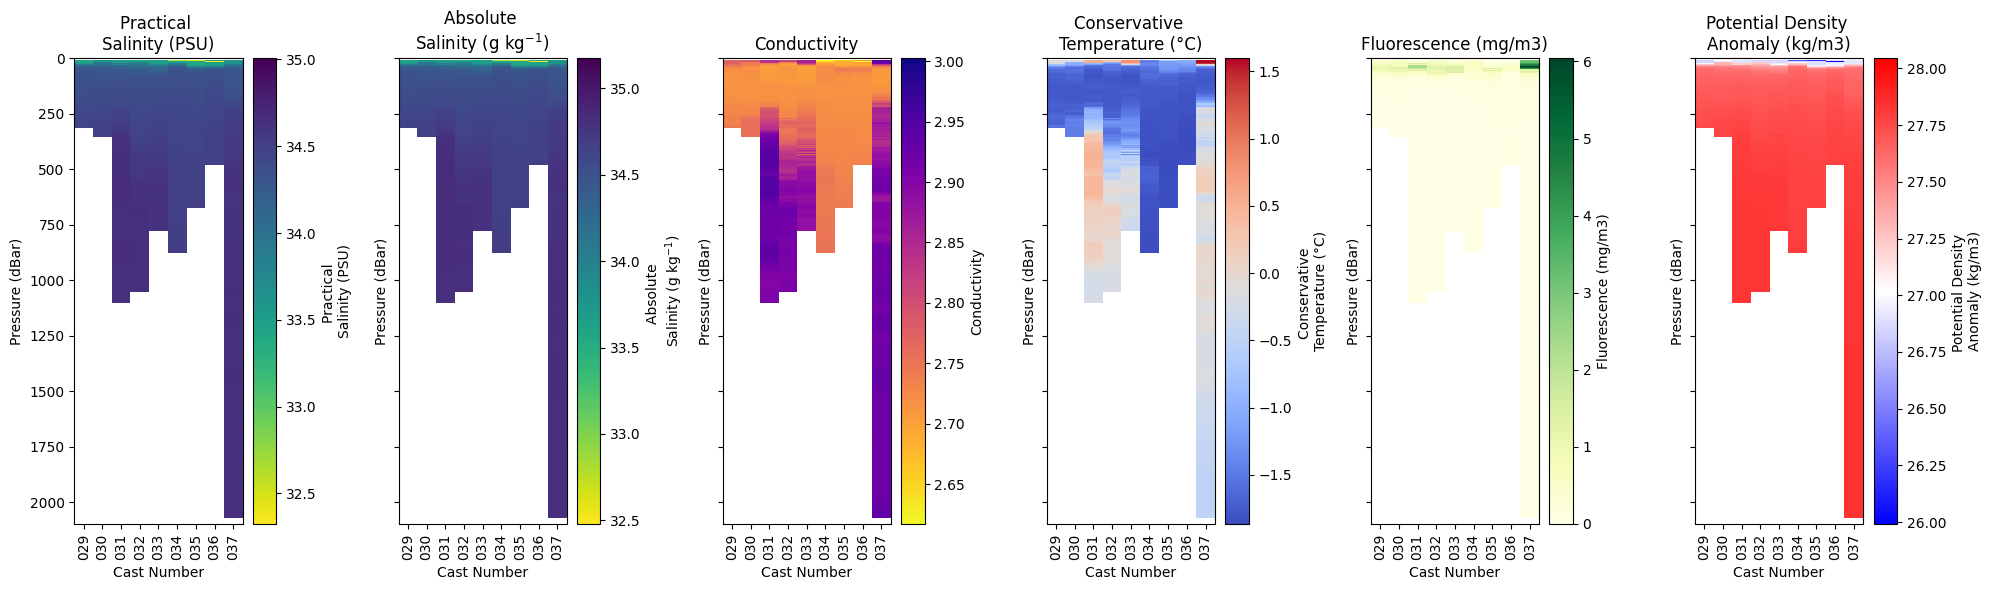

In [15]:
pressures = []
temps = []
sals = []
psals = []
conds = []
fluro = []
rho0 = []

# stations = ['002', '003', '004', '005', '006', '007', '008', '009']
# stations = ['010', '016','011', '012']  #this station list is for the northern transect of the canyon
# stations = ['015', '013', '014', '017']  #this station list is for the southern transect of the canyon
stations = ['029', '030', '031', '032', '033', '034', '035', '036', '037']
# stations = ['028']

y_min = 0
y_max = 2100

for stn in stations:
    ds = datasets[stn]

    # --- Extract variables ---
    p = ds.prDM.values
    # t = ds.t090C.values
    # s = ds.sal00.values
    t = ds.CT.values
    s = ds.SA.values
    c = ds.c0Sperm.values
    f = ds.flECO_AFL.values
    rho_anom = ds.sigma0.values
    ps = ds.sal00.values


    # --- Mask to in-water (pressure > 8.5 dbar) ---
    mask = p > 8.5
    p = p[mask]
    t = t[mask]
    s = s[mask]
    c = c[mask]
    f = f[mask]
    ps = ps[mask]
    rho_anom = rho_anom[mask]

    # --- Sort by pressure (increasing) ---
    order = np.argsort(p)
    p = p[order]
    t = t[order]
    s = s[order]
    c = c[order]
    f = f[order]
    ps = ps[order]

    rho_anom = rho_anom[order]

    # --- Append to lists ---
    pressures.append(p)
    temps.append(t)
    sals.append(s)
    conds.append(c)
    fluro.append(f)
    rho0.append(rho_anom)
    psals.append(ps)

p_min = min(p[0] for p in pressures)
p_max = max(p[-1] for p in pressures)
p_grid = np.linspace(p_min, p_max, 600)

temp_grid = np.vstack([
    np.interp(p_grid, pressures[i], temps[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

sal_grid = np.vstack([
    np.interp(p_grid, pressures[i], sals[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

cond_grid = np.vstack([
    np.interp(p_grid, pressures[i], conds[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

fluro_grid = np.vstack([
    np.interp(p_grid, pressures[i], fluro[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

rho0_grid = np.vstack([
    np.interp(p_grid, pressures[i], rho0[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])

psal_grid = np.vstack([
    np.interp(p_grid, pressures[i], psals[i], left=np.nan, right=np.nan)
    for i in range(len(stations))
])


# # x: station index
x = np.arange(len(stations))
x_edges = np.arange(len(stations) + 1)

# y: pressure edges
p_edges = np.zeros(len(p_grid) + 1)
p_edges[1:-1] = (p_grid[:-1] + p_grid[1:]) / 2
p_edges[0] = p_grid[0] - (p_grid[1] - p_grid[0]) / 2
p_edges[-1] = p_grid[-1] + (p_grid[-1] - p_grid[-2]) / 2

fig, axs = plt.subplots(1, 6, figsize=(20, 6), sharey=True)

variables = [
    (psal_grid, "Practical \nSalinity (PSU)", "viridis_r", np.nanmin(psal_grid), np.nanmax(psal_grid)),

    (sal_grid,  "Absolute \nSalinity (g kg$^{-1}$)", "viridis_r", np.nanmin(sal_grid), np.nanmax(sal_grid)),

    (cond_grid, "Conductivity", "plasma_r", np.nanmin(cond_grid), np.nanmax(cond_grid)),

    (temp_grid, "Conservative \nTemperature (°C)", "coolwarm", np.nanmin(temp_grid), np.nanmax(temp_grid)),

    (fluro_grid, "Fluorescence (mg/m3)", "YlGn", np.nanmin(fluro_grid), np.nanmax(fluro_grid)),

    (rho0_grid, 'Potential Density \nAnomaly (kg/m3)', 'bwr', np.nanmin(rho0_grid), np.nanmax(rho0_grid)),
]



for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x_edges,
        p_edges,
        var2d.T,        # shape must be (pressure, station)
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    # Set station numbers as x-ticks
    ax.set_xticks(x+0.5)
    ax.set_xticklabels(stations)
    ax.tick_params(axis='x', labelrotation=90)

    # ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Cast Number")
    ax.set_ylabel("Pressure (dBar)")


    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)


axs[0].set_ylim(y_min, y_max)
axs[0].invert_yaxis()
plt.tight_layout()
plt.show()


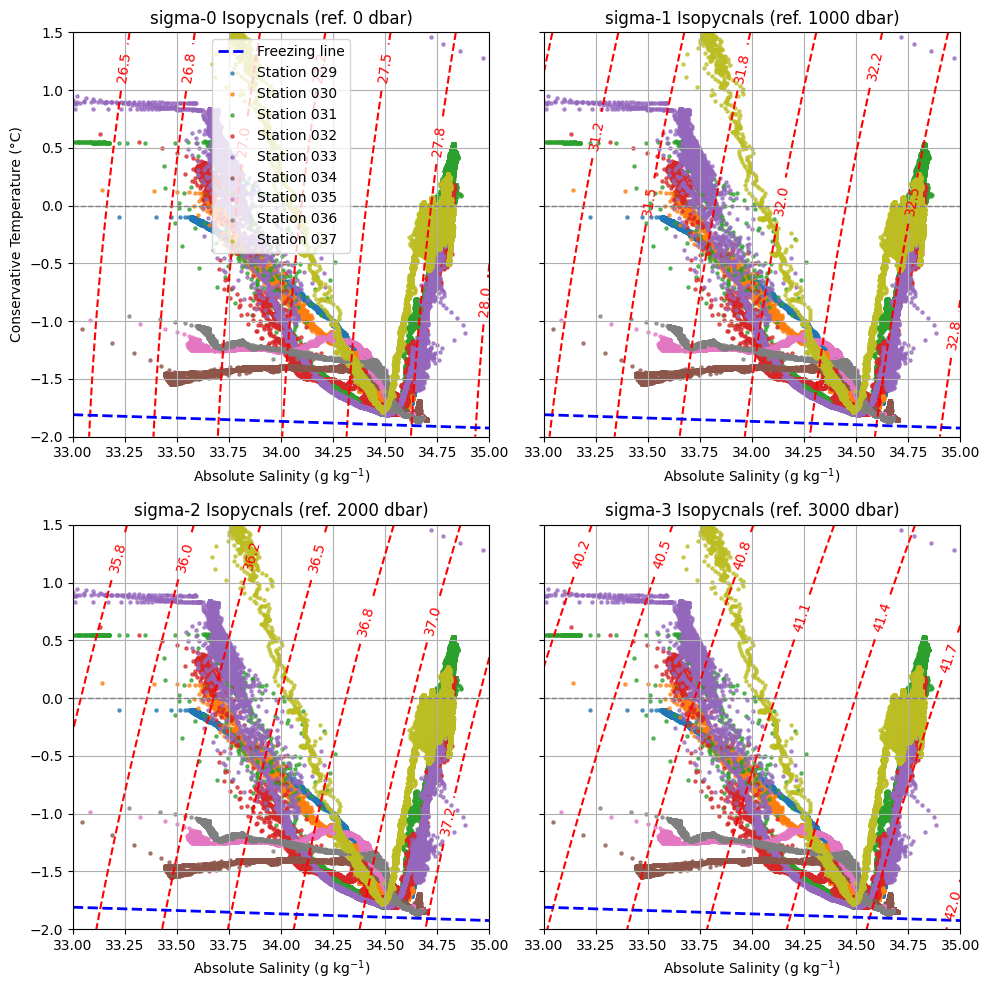

In [16]:
xmin, xmax = 33, 35
ymin, ymax = -2.0, 1.5

# Density grid
s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
ps_grid = np.linspace(xmin, xmax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)
PSg, Tg = np.meshgrid(ps_grid, t_grid)

adelie_aabw_sig2 = 37.27
ross_sea_aabw_sig2 = 37.39
surface_fp = -1.9

sigma0_grid = gsw.sigma0(Sg, Tg)
sigma1_grid = gsw.sigma1(Sg, Tg)
sigma2_grid = gsw.sigma2(Sg, Tg)
sigma3_grid = gsw.sigma3(Sg, Tg)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()


sigma_grids = [
    (sigma0_grid, 'sigma-0 Isopycnals (ref. 0 dbar)'),
    (sigma1_grid, 'sigma-1 Isopycnals (ref. 1000 dbar)'),
    (sigma2_grid, 'sigma-2 Isopycnals (ref. 2000 dbar)'),
    (sigma3_grid, 'sigma-3 Isopycnals (ref. 3000 dbar)')
]

for ax, (sigma_grid, title) in zip(axs, sigma_grids):

    cs = ax.contour(Sg, Tg, sigma_grid, colors='red', linestyles='--')
    ax.clabel(cs, fmt='%1.1f')

    # Freezing line (TEOS-10)
    ax.plot(
        s_grid,
        gsw.CT_freezing(s_grid, 0, 10 ), #10 here is because surface water at ~10dbar
        color='blue',
        linewidth=2,
        linestyle='--',
        label='Freezing line'
    )

    # CTD casts
    for i, stn in enumerate(stations):
        ax.scatter(
            sals[i], temps[i],
            s=5,
            label=f'Station {stn}',
            alpha=0.7
        )

    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
    ax.set_title(title)
    ax.grid(True)

# Only left panel needs y-label
axs[0].set_ylabel('Conservative Temperature (°C)')
axs[0].legend()

plt.tight_layout()
plt.show()


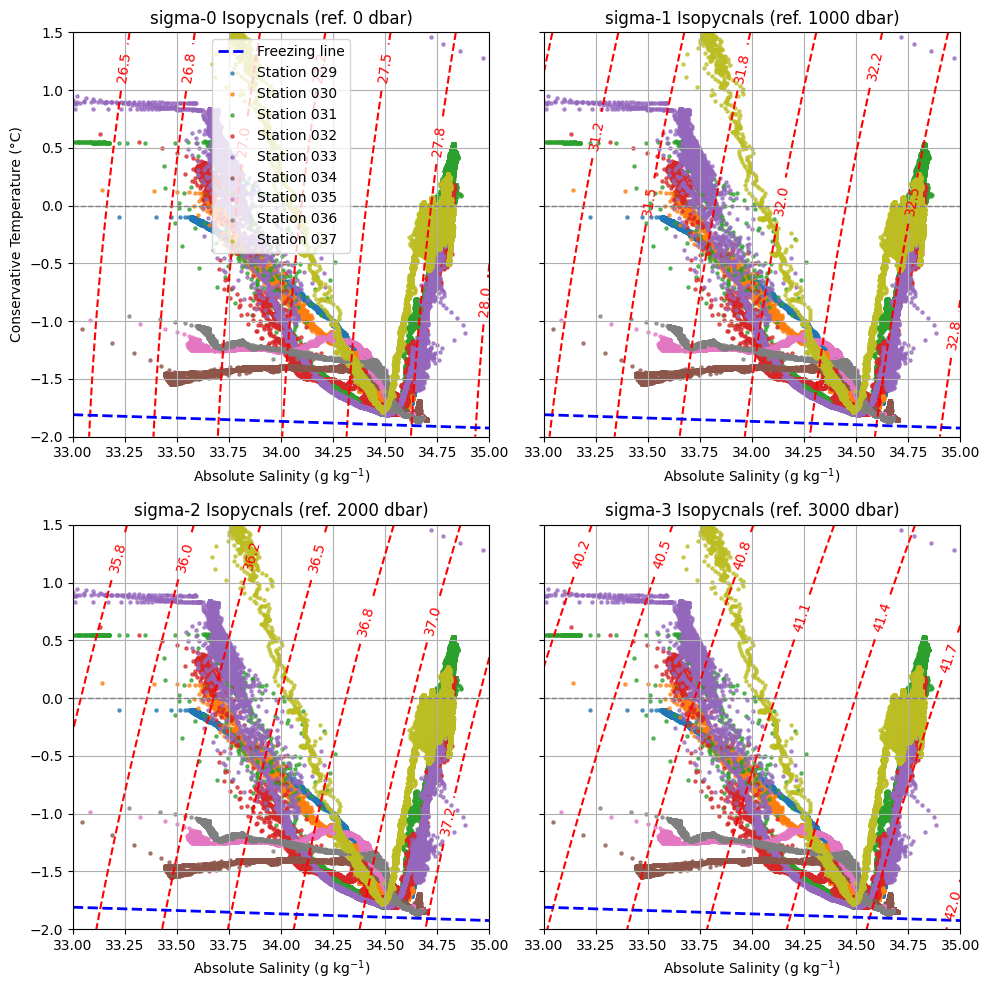

In [17]:
xmin, xmax = 33, 35
ymin, ymax = -2.0, 1.5

# Density grid
s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
ps_grid = np.linspace(xmin, xmax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)
PSg, Tg = np.meshgrid(ps_grid, t_grid)

adelie_aabw_sig2 = 37.27
ross_sea_aabw_sig2 = 37.39
surface_fp = -1.9
pd_0 = [27.50, 27.70]
pd_1 = 32.45
pd_3 = 41.68

sigma0_grid = gsw.sigma0(Sg, Tg)
sigma1_grid = gsw.sigma1(Sg, Tg)
sigma2_grid = gsw.sigma2(Sg, Tg)
sigma3_grid = gsw.sigma3(Sg, Tg)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()


sigma_grids = [
    (sigma0_grid, 'sigma-0 Isopycnals (ref. 0 dbar)'),
    (sigma1_grid, 'sigma-1 Isopycnals (ref. 1000 dbar)'),
    (sigma2_grid, 'sigma-2 Isopycnals (ref. 2000 dbar)'),
    (sigma3_grid, 'sigma-3 Isopycnals (ref. 3000 dbar)')
]

for ax, (sigma_grid, title) in zip(axs, sigma_grids):

    cs = ax.contour(Sg, Tg, sigma_grid, colors='red', linestyles='--')
    ax.clabel(cs, fmt='%1.1f')

    # Freezing line (TEOS-10)
    ax.plot(
        s_grid,
        gsw.CT_freezing(s_grid, 0, 10 ), #10 here is because surface water at ~10dbar
        color='blue',
        linewidth=2,
        linestyle='--',
        label='Freezing line'
    )

    # CTD casts
    for i, stn in enumerate(stations):
        ax.scatter(
            sals[i], temps[i],
            s=5,
            label=f'Station {stn}',
            alpha=0.7
        )

    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
    ax.set_title(title)
    ax.grid(True)

# Only left panel needs y-label
axs[0].set_ylabel('Conservative Temperature (°C)')
axs[0].legend()

plt.tight_layout()
plt.show()


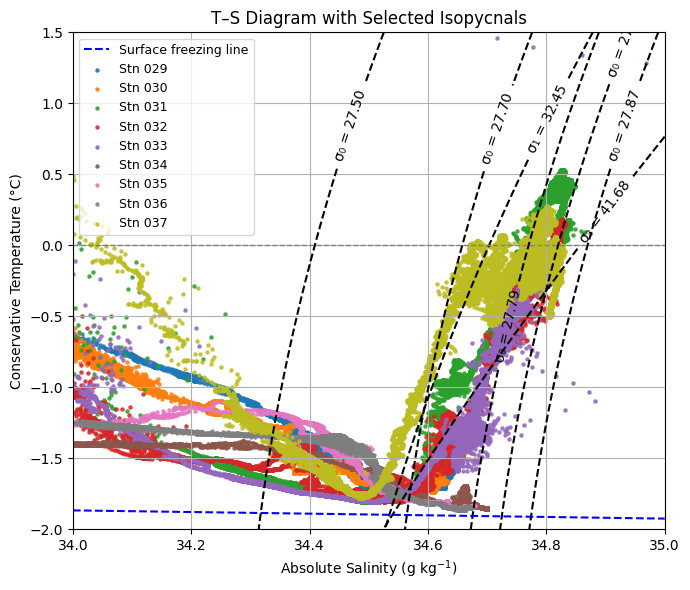

In [24]:
xmin, xmax = 34, 35
ymin, ymax = -2, 1.5

# Density grid
s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)

surface_fp = -1.9
pd_0 = [27.50, 27.70, 27.79, 27.83, 27.87]   # sigma-0 contours
pd_1 = [32.45]         # sigma-1 contour
pd_3 = [41.68]         # sigma-3 contour

# Compute density fields
sigma0_grid = gsw.sigma0(Sg, Tg)
sigma1_grid = gsw.sigma1(Sg, Tg)
sigma3_grid = gsw.sigma3(Sg, Tg)

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))

# Sigma-0 contours
cs0 = ax.contour(
    Sg, Tg, sigma0_grid,
    levels=pd_0,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs0, fmt='σ₀ = %.2f')

# Sigma-1 contour
cs1 = ax.contour(
    Sg, Tg, sigma1_grid,
    levels=pd_1,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs1, fmt='σ₁ = %.2f')

# Sigma-3 contour
cs3 = ax.contour(
    Sg, Tg, sigma3_grid,
    levels=pd_3,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs3, fmt='σ₃ = %.2f')

# Freezing line (surface)
ax.plot(
    s_grid,
    gsw.CT_freezing(s_grid, 0, 10),  # ~10 dbar surface
    color='blue',
    linewidth=1.5,
    linestyle='--',
    # label='Surface freezing line'
)

# CTD casts
for i, stn in enumerate(stations):
    ax.scatter(
        sals[i], temps[i],
        s=5,
        alpha=0.8,
        label=f'Stn {stn}'
    )


ax.axhline(0, color='grey', linestyle='--', linewidth=1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative Temperature (°C)')
ax.set_title('T–S Diagram with Selected Isopycnals')


legend_elements = [
    Line2D(
        [0], [0],
        color='blue',
        linestyle='--',
        linewidth=1.5,
        label='Surface freezing line'
    )
]

handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles=legend_elements + handles,
    labels=[h.get_label() for h in legend_elements] + labels,
    loc='upper left',
    fontsize=9,
    frameon=True
)


ax.grid(True)

plt.tight_layout()
plt.show()


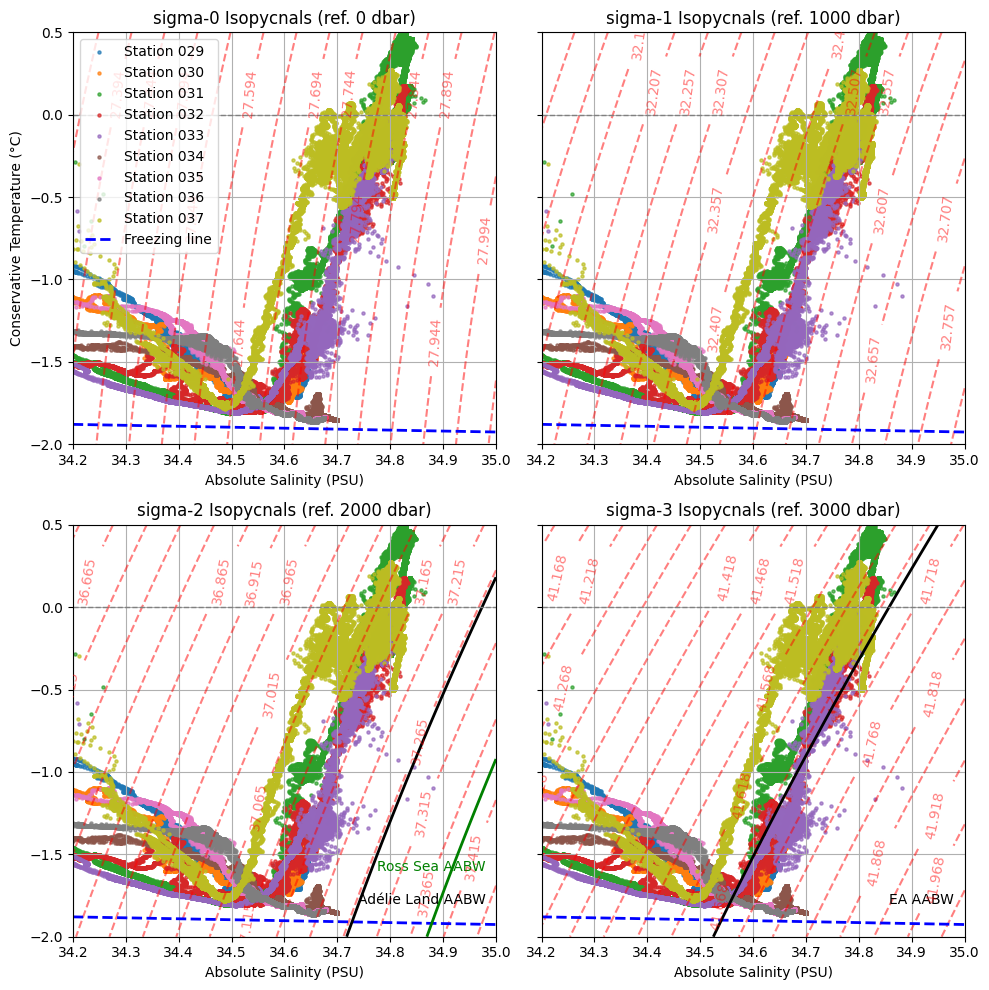

In [19]:
xmin, xmax = 34, 35
ymin, ymax = -2.0, 1.5

# Density grid
s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)

adelie_aabw_sig2 = 37.27
ross_sea_aabw_sig2 = 37.39
eais_aabw_sig3 = 41.68
surface_fp = -1.9

sigma0_grid = gsw.sigma0(PSg, Tg)
sigma1_grid = gsw.sigma1(PSg, Tg)
sigma2_grid = gsw.sigma2(PSg, Tg)
sigma3_grid = gsw.sigma3(PSg, Tg)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()

sigma_grids = [
    (sigma0_grid, 'sigma-0 Isopycnals (ref. 0 dbar)'),
    (sigma1_grid, 'sigma-1 Isopycnals (ref. 1000 dbar)'),
    (sigma2_grid, 'sigma-2 Isopycnals (ref. 2000 dbar)'),
    (sigma3_grid, 'sigma-3 Isopycnals (ref. 3000 dbar)')
]

for ax, (sigma_grid, title) in zip(axs, sigma_grids):

    # Background sigma contours
    # cs = ax.contour(PSg, Tg, sigma_grid, colors='red', linestyles='--')
    # Define contour levels at 0.025 spacing
    levels = np.arange(
        np.nanmin(sigma_grid),
        np.nanmax(sigma_grid),
        0.05
    )

    cs = ax.contour(
        PSg, Tg, sigma_grid,
        levels=levels,
        colors='red',
        linestyles='--',
        alpha = 0.5,
    )

    ax.clabel(cs, fmt='%1.3f')

    # CTD casts
    for i, stn in enumerate(stations):
        ax.scatter(
            sals[i], temps[i],
            s=5,
            label=f'Station {stn}',
            alpha=0.7
        )

    # Freezing line (TEOS-10)
    ax.plot(
        s_grid,
        gsw.CT_freezing(s_grid, 0, 10), #10 here is because surface water is at ~10dbar
        color='blue',
        linewidth=2,
        linestyle='--',
        label='Freezing line'
    )

    # Only add AABW reference lines on sigma-2 panel
    if 'sigma-2' in title:

        ax.contour(
            PSg, Tg, sigma2_grid,
            levels=[adelie_aabw_sig2],
            colors='black',
            linewidths=2,
            linestyles='-'
        )

        ax.contour(
            PSg, Tg, sigma2_grid,
            levels=[ross_sea_aabw_sig2],
            colors='green',
            linewidths=2,
            linestyles='-'
        )

        ax.text(
            xmax - 0.02, ymin + 0.2,
            'Adélie Land AABW',
            color='black',
            ha='right'
        )

        ax.text(
            xmax - 0.02, ymin + 0.4,
            'Ross Sea AABW',
            color='green',
            ha='right'
        )

    if 'sigma-3' in title:
        ax.contour(
            PSg, Tg, sigma3_grid,
            levels=[eais_aabw_sig3],
            colors='black',
            linewidths=2,
            linestyles='-'
        )

        ax.text(
            xmax - 0.02, ymin + 0.2,
            'EA AABW',
            color='black',
            ha='right'
        )

    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Absolute Salinity (PSU)')
    ax.set_title(title)
    ax.grid(True)

# Only left panel needs y-label
axs[0].set_ylabel('Conservative Temperature (°C)')
axs[0].legend()

plt.tight_layout()
plt.show()


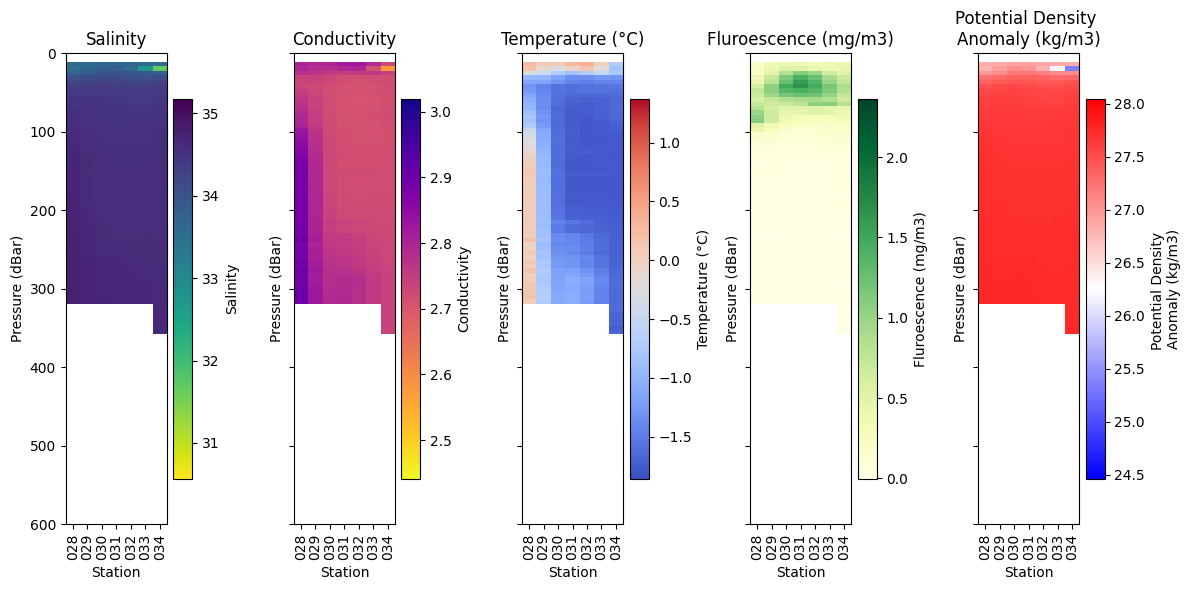

In [51]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Build smoothed transect grids
# -----------------------------

sigma = 1.0
y_min = 0
y_max = 600

sal_grid_smooth  = gaussian_filter1d(sal_grid,  sigma=sigma, axis=0)
temp_grid_smooth = gaussian_filter1d(temp_grid, sigma=sigma, axis=0)
cond_grid_smooth = gaussian_filter1d(cond_grid, sigma=sigma, axis=0)
fluro_grid_smooth = gaussian_filter1d(fluro_grid, sigma=sigma, axis=0)
rho0_grid_smooth = gaussian_filter1d(rho0_grid, sigma=sigma, axis=0)

# -----------------------------
# 2. Plot smoothed transects
# -----------------------------

fig, axs = plt.subplots(1, 5, figsize=(12, 6), sharey=True)

variables = [
    (sal_grid_smooth,  "Salinity",        "viridis_r", np.nanmin(sal_grid), np.nanmax(sal_grid)),

    (cond_grid_smooth, "Conductivity",    "plasma_r", np.nanmin(cond_grid), np.nanmax(cond_grid)),

    (temp_grid_smooth, "Temperature (°C)", "coolwarm", np.nanmin(temp_grid), np.nanmax(temp_grid)),

    (fluro_grid_smooth, "Fluroescence (mg/m3)", "YlGn", np.nanmin(fluro_grid), np.nanmax(fluro_grid)),

    (rho0_grid_smooth, 'Potential Density \nAnomaly (kg/m3)', 'bwr', np.nanmin(rho0_grid), np.nanmax(rho0_grid)),
]

for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x,          # station edges
        p_grid,          # pressure edges
        var2d.T,          # (pressure, station)
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    # Set station numbers as x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(stations)
    ax.tick_params(axis='x', labelrotation=90)

    # ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Cast Number")
    ax.set_ylabel("Pressure (dBar)")

    # ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_ylabel("Pressure (dBar)")

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)

axs[0].set_ylim(y_min, y_max)
axs[0].invert_yaxis()
plt.tight_layout()
plt.show()


In [52]:
# extract salinty, temperature, potential density gradients for each CTD cast (Laura to plot against internal waves)

print(stations)

['028', '029', '030', '031', '032', '033', '034']
